## REINFORCE algorithm

In [8]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn import Sequential, Linear, LeakyReLU, Softmax
from torch.optim import Adam

In [90]:
env = gym.make('CartPole-v0')
GPU = torch.device('cuda:0')
action_space = [0, 1]
dim_input = 4
dim_hidden = 150
dim_output = len(action_space)
learn_rate = 9e-4

model = Sequential(
    Linear(dim_input, dim_hidden),
    LeakyReLU(),
    Linear(dim_hidden, dim_output),
    Softmax(dim = -1)
)

model = model.to(GPU)

optimizer = Adam(model.parameters(), lr = learn_rate)

In [91]:
def discount_rewards(rewards, gamma = 0.99):
    gamma = torch.tensor(gamma).to(GPU, dtype = torch.float)
    exponents = torch.arange(len(rewards)).to(GPU, dtype = torch.float)
    disc_rewards = torch.pow(gamma, exponents) * rewards
    disc_rewards = disc_rewards / disc_rewards.max()
    return disc_rewards

def loss_fun(probs, disc_rewards):
    return -1 * torch.sum(disc_rewards * torch.log(probs))

In [92]:
max_episodes = 1_000
max_actions = 200
len_episodes = []

# ----------------- Game starts -----------------
for i_episode in range(max_episodes):
    # Update state
    state = env.reset()
    finished = False
    transitions = []
    # ----------------- Episode starts -----------------
    for i_action in range(max_actions):
        state_torch = torch.from_numpy(state).to(GPU, dtype = torch.float)
        # Get action probabilities
        probs = model(state_torch).cpu().data.numpy()
        # Select action stochastically
        action = np.random.choice(action_space, p = probs)
        # Save (s, a, a_i) tuple
        transitions.append((state, action, i_action + 1))
        # Take action
        new_state, _, finished, _ = env.step(action)
        # Update state
        state = new_state     
        # Check if game is lost
        if finished == True:
            break
    # ----------------- Episode ends -----------------
    # Save episode length
    len_episodes.append(len(transitions))
    # Collect rewards from episode and discount them
    rewards_epi = torch.tensor([r for (s, a, r) in transitions]).flip(dims = (0,)).to(GPU, dtype = torch.float)
    rewards_epi = discount_rewards(rewards_epi)
    # Collect states from episode
    states_epi = torch.tensor([s for (s, a, r) in transitions]).to(GPU, dtype = torch.float)
    # Collection actions from episode
    actions_epi = torch.tensor([a for (s, a, r) in transitions]).to(GPU, dtype = torch.float)
    # Re-compute action probabilities for all states in episode
    probs_epi = model(states_epi)
    # Subset the probabilities associated with actions that were chosen
    probs_epi = probs_epi.gather(dim = 1, index = actions_epi.long().view(-1, 1)).squeeze()
    # Compute loss
    loss_epi = loss_fun(probs_epi, rewards_epi)
    # Update model parameters
    optimizer.zero_grad()
    loss_epi.backward()
    optimizer.step()
    # Print progress
    if i_episode % 100 == 0:
        print(f'Epoch: {(i_episode + 1):04d} | Loss: {loss_epi.item():.4f}')
# ----------------- Game ends -----------------        

Epoch: 0001 | Loss: 4.4302
Epoch: 0101 | Loss: 10.2596
Epoch: 0201 | Loss: 6.5195
Epoch: 0301 | Loss: 8.8182
Epoch: 0401 | Loss: 13.9283
Epoch: 0501 | Loss: 23.5974
Epoch: 0601 | Loss: 30.0981
Epoch: 0701 | Loss: 24.9073
Epoch: 0801 | Loss: 33.8331
Epoch: 0901 | Loss: 13.3422


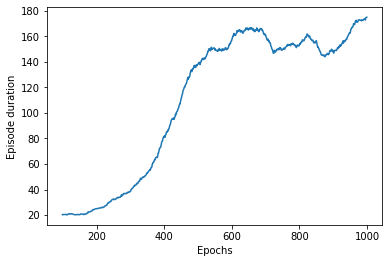

In [93]:
len_episodes = pd.Series(len_episodes)
len_episodes = len_episodes.rolling(100).mean()

plt.plot(len_episodes)
plt.ylabel('Episode duration')
plt.xlabel('Epochs');